In [6]:
library(ggplot2)
library(scattermore)
# integration data
# 

# https=//satijalab.org/seurat/articles/seurat5_integration

.libPaths(c('/sc/arion/projects/CommonMind/liting/conda/envs/Py39_R43_Ju10/lib/R/library',.libPaths()))
library(RColorBrewer)
library(scales)
library(schard)
library(SeuratWrappers)
library(ggVennDiagram)
library(Seurat)
library(slingshot)
library(ComplexHeatmap)
library(circlize)
library(dplyr)
library(zellkonverter)
# functions 
# intergrate NN and ENT data, and perform trajectory inference

library(Seurat)
library(dplyr)
library(Seurat)
library(patchwork)

library(BiocManager)

library(scuttle)
library(reticulate)
library(Seurat)
library(uwot)
library(stringr)


library(ggplot2)
library(ggplot2)
library(scattermore)

# https=//satijalab.org/seurat/articles/seurat5_integration
# intergrate NN and ENT data, and perform trajectory inference
options(repr.plot.width = 7, repr.plot.height = 5)

In [3]:
ent_N <- readRDS('/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/ent_nn_merge_cca.rds')
ent_N[["RNA"]] <- as(object = ent_N[["RNA"]], Class = "Assay5")
ent_N <- JoinLayers(ent_N)

lister <- readH5AD('/sc/arion/projects/CommonMind/aging/hui/files/lister_processed.h5ad', use_hdf5=TRUE, verbose=F)
lister@colData$stage_celltype <- paste(lister@colData$stage_id,lister@colData$major_clust)

Warning message:
“The names of these selected uns$major_clust_colors_dict items have been
modified to match R conventions: 'L2-3_CUX2' -> 'L2.3_CUX2', 'L5-6_THEMIS' ->
'L5.6_THEMIS', 'L5-6_TLE4' -> 'L5.6_TLE4', and 'Poor-Quality' -> 'Poor.Quality'”
Warning message:
“The names of these selected uns items have been modified to match R
conventions: 'Astro_GFAP_dev-traj_colors' -> 'Astro_GFAP_dev.traj_colors',
'Astro_SLC1A2_dev-traj_colors' -> 'Astro_SLC1A2_dev.traj_colors',
'CCK_RELN_dev-traj_colors' -> 'CCK_RELN_dev.traj_colors',
'CCK_SORCS1_dev-traj_colors' -> 'CCK_SORCS1_dev.traj_colors',
'CCK_SYT6_dev-traj_colors' -> 'CCK_SYT6_dev.traj_colors',
'ID2_CSMD1_dev-traj_colors' -> 'ID2_CSMD1_dev.traj_colors',
'L2_CUX2_LAMP5_dev-traj_colors' -> 'L2_CUX2_LAMP5_dev.traj_colors',
'L3_CUX2_PRSS12_dev-traj_colors' -> 'L3_CUX2_PRSS12_dev.traj_colors',
'L4_RORB_LRRK1_dev-traj_colors' -> 'L4_RORB_LRRK1_dev.traj_colors',
'L4_RORB_MET_dev-traj_colors' -> 'L4_RORB_MET_dev.traj_colors',
'L4_RORB_MME_dev

In [54]:
#lister <- readH5AD('/sc/arion/projects/CommonMind/aging/hui/files/lister_processed.h5ad', use_hdf5=TRUE, verbose=F)
lister_hvg <- read.csv('lister_hvg.csv')


#meta.data <- subset(lister@colData, cell_type %in% c("PN") )
meta.data <- subset(lister@colData , !cell_type %in%c('Poor-Quality'))
set.seed(123)

meta.data$name <- rownames(meta.data)
#meta.data <- meta.data[sample(1:nrow(meta.data),50000),]
ExN_data <- lister[,rownames(meta.data)]

# meta.data <- as.data.frame(meta.data)%>%group_by(stage_id)%>%sample_n(3000)
# ExN_data <- lister[,meta.data$name]




ExN_data <- CreateSeuratObject(counts = as(ExN_data@assays@data$X,"sparseMatrix"), meta.data = meta.data)
ExN_data$major_clust <- meta.data$major_clust
ExN_data$stage_id <- meta.data$stage_id
ExN_data$cluster_stage <- paste( ExN_data$stage_id, ExN_data$major_clust)


library(edgeR)
load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph.RData')

# pseudo_bulk
pseudo_cluster <- as.data.frame(AggregateExpression(ExN_data, assays = "RNA", return.seurat = F, group.by = c('major_clust', "cluster_stage",'stage_id')[1])$RNA)

# pseudo_bulk ENT
ent_N$cca_N_types_stage_dataset <- paste(ent_N$cca_N_types_stage,ent_N$dataset)
pseudo_cluster_ENT <- as.data.frame(AggregateExpression(ent_N, assays = "RNA", return.seurat = F, group.by = c("cca_N_types_stage"))$RNA)#'dataset',

pseudo_cluster <- log(cpm(pseudo_cluster+1))
pseudo_cluster_ENT <- log(cpm(pseudo_cluster_ENT+1))
colnames(pseudo_cluster_ENT) <- gsub('-','_',colnames(pseudo_cluster_ENT))
colnames(pseudo_cluster) <- gsub('-','_',colnames(pseudo_cluster))

lister_hvgs <- lister_hvg$X[lister_hvg$highly_variable=='True']


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“[[<- defined for objects of type "S4" only for subclasses of environment”


In [55]:
ExN_data <- FindVariableFeatures(ExN_data, nfeatures = 3000)
ent_N <- FindVariableFeatures(ent_N, nfeatures = 3000) # for identify DEGs using slingshot

Finding variable features for layer counts

Finding variable features for layer counts



In [56]:

corr_he <- c()
for (ct1 in colnames(pseudo_cluster_ENT)){
    for (ct2 in colnames(pseudo_cluster)){
        
        intersect_genes <- intersect( rownames(pseudo_cluster), rownames(pseudo_cluster_ENT))
        intersect_genes <- intersect(intersect(VariableFeatures(ExN_data),intersect_genes),VariableFeatures(ent_N))
        #intersect_genes <- intersect(intersect(lister_hvgs,intersect_genes),VariableFeatures(ent_N))
        pseudo_clusterx <- pseudo_cluster[intersect_genes,ct2]
        pseudo_cluster_ENTx <- pseudo_cluster_ENT[intersect_genes,ct1]
        x= cor(pseudo_clusterx,pseudo_cluster_ENTx,method = 'pearson')
        names(x) <- paste(ct1,ct2)
        corr_he <- c(corr_he,x)
    } 
}

corr_he <- as.data.frame(corr_he)
corr_he$OSN <- str_split(rownames(corr_he),pattern = ' ',simplify = T)[,1]
corr_he$Brain <- str_split(rownames(corr_he),pattern = ' ',simplify = T)[,2]

#corr_he$OSN <- str_split(rownames(corr_he),pattern = ' ',simplify = T)[,1]

# corr_he$Brain <- str_split(rownames(corr_he),pattern = ' ',simplify = T)[,3]

# corr_he$OSN <- paste(str_split(rownames(corr_he),pattern = ' ',simplify = T)[,1], 
#                        str_split(rownames(corr_he),pattern = ' ',simplify = T)[,2])


Warning message in geom_tile(aes(mapping = corr_he)):
“Ignoring unknown aesthetics: mapping”


pdf 
  2

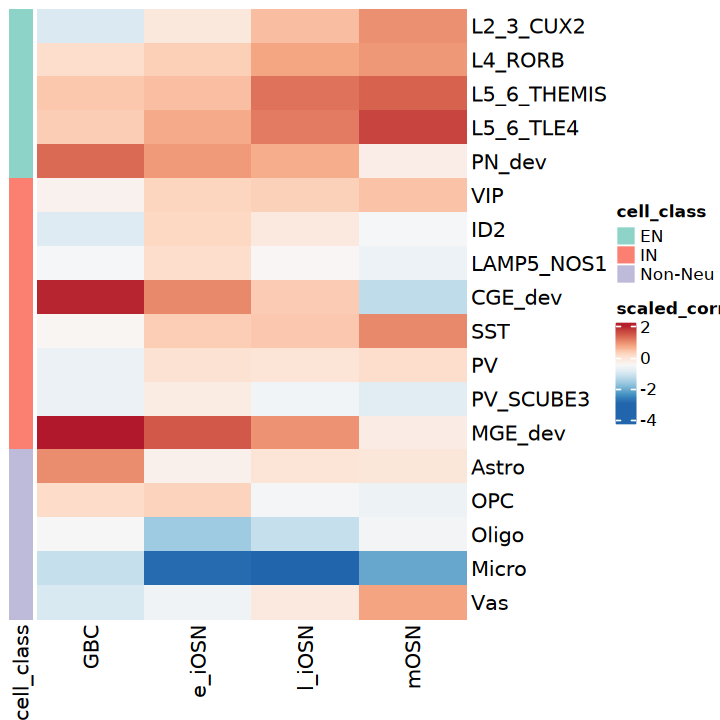

In [57]:
#corr_he
options(repr.plot.width = 6, repr.plot.height = 6) 
ggplot(corr_he, aes(x=OSN, y=Brain, fill=corr_he))+
geom_tile(aes(mapping = corr_he))

library(tidyr)
library(dplyr)
library(tibble)

xxx <- corr_he %>%
  pivot_wider(names_from = Brain, values_from = corr_he,id_cols = OSN)


xxx <- column_to_rownames(xxx, var = "OSN")
xxxx <- apply(xxx,1,scale)
rownames(xxxx) <- colnames(xxx)

celltype_meta <- lister@colData[,c( 'major_clust',"cell_type")]
rownames(celltype_meta) <- celltype_meta$major_clust
celltype_meta$cell_type <- as.character(celltype_meta$cell_type)
celltype_meta$cell_type[celltype_meta$cell_type=='PN'] <- 'EN'

cell_typecolor <- c( 'EN'= "#8DD3C7",'IN'=  "#FB8072",'Non-Neu'= "#BEBADA")
rownames(celltype_meta) <- gsub('-','_',rownames(celltype_meta))
 


ComplexHeatmap::draw(Heatmap(
    xxxx[,c(2,1,3,4)],    
    cluster_rows = F,
    cluster_columns              = F,
    name='scaled_corr',
    col= colorRamp2(seq(from=min(xxxx),to=max(xxxx),length=9),rev(brewer.pal(11, "RdBu")[c(-1,-11)])),
    row_gap = unit(c(2.5), "mm"),
    show_row_names               = T,
    show_column_names            = T,
    show_row_dend = T,
        left_annotation = rowAnnotation(
    cell_class= celltype_meta[rownames(xxxx),'cell_type'],
   col = list(cell_class = cell_typecolor)
  )
))




#dev.print(pdf, file='./figures/osn_enstage_corr.pdf', height=4, width=5)

dev.print(pdf, file=paste0('./figures/osn_major_clust.pdf'), height=6, width=5)

In [48]:
#lister <- readH5AD('/sc/arion/projects/CommonMind/aging/hui/files/lister_processed.h5ad', use_hdf5=TRUE, verbose=F)
lister_hvg <- read.csv('lister_hvg.csv')


meta.data <- subset(lister@colData, cell_type %in% c("PN") )
#meta.data <- subset(lister@colData , !cell_type %in%c('Poor-Quality'))
set.seed(123)
#meta.data <- meta.data[sample(1:nrow(meta.data),50000),]

ExN_data <- lister[,rownames(meta.data)]

ExN_data <- CreateSeuratObject(counts = as(ExN_data@assays@data$X,"sparseMatrix"), meta.data = meta.data)
ExN_data$major_clust <- meta.data$major_clust
ExN_data$stage_id <- meta.data$stage_id
ExN_data$cluster_stage <- paste( ExN_data$stage_id, ExN_data$major_clust)


library(edgeR)
load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph.RData')

# pseudo_bulk
pseudo_cluster <- as.data.frame(AggregateExpression(ExN_data, assays = "RNA", return.seurat = F, group.by = c('major_clust', "cluster_stage",'stage_id')[3])$RNA)

# pseudo_bulk ENT
pseudo_cluster_ENT <- as.data.frame(AggregateExpression(ent_N, assays = "RNA", return.seurat = F, group.by = c("cca_N_types_stage"))$RNA)#'dataset',

pseudo_cluster <- log(cpm(pseudo_cluster+1))
pseudo_cluster_ENT <- log(cpm(pseudo_cluster_ENT+1))
colnames(pseudo_cluster_ENT) <- gsub('-','_',colnames(pseudo_cluster_ENT))
colnames(pseudo_cluster) <- gsub('-','_',colnames(pseudo_cluster))

lister_hvgs <- lister_hvg$X[lister_hvg$highly_variable=='True']


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“[[<- defined for objects of type "S4" only for subclasses of environment”


In [52]:

corr_he <- c()
ExN_data <- FindVariableFeatures(ExN_data, nfeatures = 2000)
ent_N <- FindVariableFeatures(ent_N, nfeatures = 2000) # for identify DEGs using slingshotcorr_he <- c()
for (ct1 in colnames(pseudo_cluster_ENT)){
    for (ct2 in colnames(pseudo_cluster)){
        
        intersect_genes <- intersect( rownames(pseudo_cluster), rownames(pseudo_cluster_ENT))
        #intersect_genes <- intersect(intersect(lister_hvgs,intersect_genes),VariableFeatures(ent_N))
        intersect_genes <- intersect(intersect(VariableFeatures(ExN_data),intersect_genes),VariableFeatures(ent_N))
        
        pseudo_clusterx <- pseudo_cluster[intersect_genes,ct2]
        pseudo_cluster_ENTx <- pseudo_cluster_ENT[intersect_genes,ct1]
        x= cor(pseudo_clusterx,pseudo_cluster_ENTx,method = 'pearson')
        
        names(x) <- paste(ct1,ct2)
        corr_he <- c(corr_he,x)
    } 
}

corr_he <- as.data.frame(corr_he)
corr_he$OSN <- str_split(rownames(corr_he),pattern = ' ',simplify = T)[,1]
corr_he$Brain <- str_split(rownames(corr_he),pattern = ' ',simplify = T)[,2]



Finding variable features for layer counts

Finding variable features for layer counts



Warning message in geom_tile(aes(mapping = corr_he)):
“Ignoring unknown aesthetics: mapping”


pdf 
  2

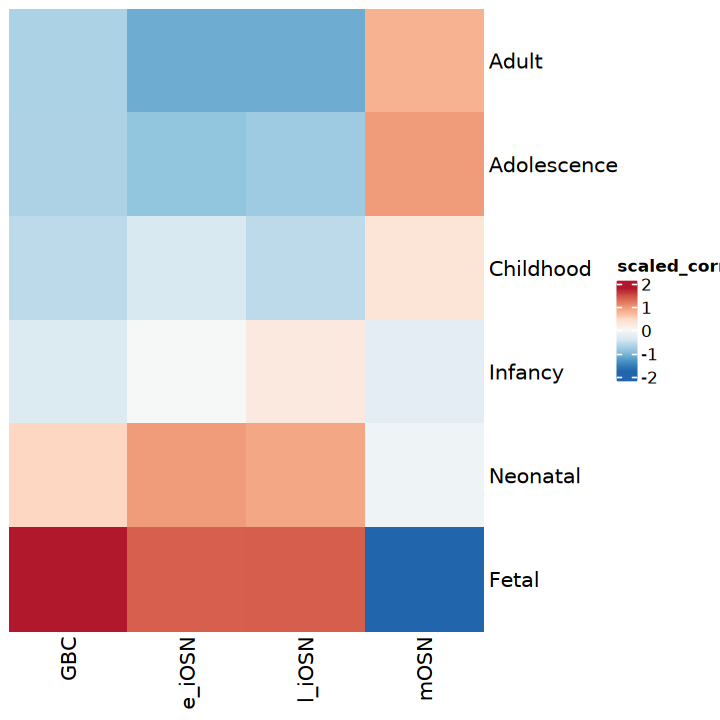

In [53]:
#corr_he
options(repr.plot.width = 6, repr.plot.height = 6) 
ggplot(corr_he, aes(x=OSN, y=Brain, fill=corr_he))+
geom_tile(aes(mapping = corr_he))

library(tidyr)
library(dplyr)
library(tibble)

xxx <- corr_he %>%
  pivot_wider(names_from = Brain, values_from = corr_he,id_cols = OSN)


xxx <- column_to_rownames(xxx, var = "OSN")
xxxx <- apply(xxx,1,scale)
rownames(xxxx) <- colnames(xxx)



ComplexHeatmap::draw(Heatmap(
    xxxx[rev(c(4,6,5,3,1,2)),c(2,1,3,4)],    
    cluster_rows = F,
    cluster_columns              = F,
    name='scaled_corr',
    col= colorRamp2(seq(from=min(xxxx),to=max(xxxx),length=9),rev(brewer.pal(11, "RdBu")[c(-1,-11)])),
    row_gap = unit(c(2.5), "mm"),
    show_row_names               = T,
    show_column_names            = T,
    show_row_dend = T,

  
))




dev.print(pdf, file='./figures/osn_enstage_corr.pdf', height=4, width=4.5)

#dev.print(pdf, file=paste0('./figures/osn_major_clust.pdf'), height=6, width=5)